### 1. Reading in James' simulation data using Pandas

In [1]:
import os

# Disable GPU
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import pandas as pd

file_path = 'dtag/grid/4_agents/4/velocity_metrics.csv'
file_path2 = 'dtag/grid/4_agents/4/idleness.csv'
file_path3 = 'dtag/grid/4_agents/4/vulnerabilities.csv'
file_path4 = 'dtag/grid/4_agents/4/distance_metrics.csv'

df_vel = pd.read_csv(file_path, sep=';', header=None)
df_idle = pd.read_csv(file_path2, sep=';',header=None)
df_vuln = pd.read_csv(file_path3, sep=';',header=None)
df_dist = pd.read_csv(file_path4, sep=';',header=None)

### 2. Cleaning and reshaping data

In [2]:
import numpy as np

N = len(df_vel.T)-1 # number of nodes in the enviroment

# remove timestep column
vel_data = df_vel.iloc[:, 1:N+1]
idle_data = df_idle.iloc[:, 1:N+1].copy() # use copy to avoid modifcation warning
idle_data[idle_data < 0] = np.nan # set negative idle values to NaN for later removal
vuln_data = df_vuln.iloc[:, 1:N+1]
dist_data = df_dist.iloc[:, 1:N+1]

# combine datasets 
df = pd.concat([vel_data,idle_data,dist_data,vuln_data],axis=1)
df = df.replace([np.inf, -np.inf], np.nan) # set all inf values to NaN for later removal

# Drop rows with NaN values
df = df.dropna()

# attack length threshold to determine attack success and update to binary classification:
threshold = 50
for col in range(N*3,N*4):
    df.iloc[:, col] = (df.iloc[:, col] >= threshold).astype(int)

# convert data to array
dataset = df.to_numpy()

# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
trainX, trainY, testX, testY = dataset[0:train_size,0:-N], dataset[0:train_size,N*3:N*4],dataset[train_size:len(dataset),0:-N], dataset[train_size:len(dataset),N*3:N*4] 
#split is appropriate as it trains on the first set of timestep values

# reshape data to appropriate format as (timestep, number of nodes, number of features)
trainX = np.reshape(trainX, (trainX.shape[0],trainX.shape[-1]//3,3))
testX = np.reshape(testX, (testX.shape[0],testX.shape[-1]//3,3))

### 3. Create adjacency matrix for data's respective enviroment

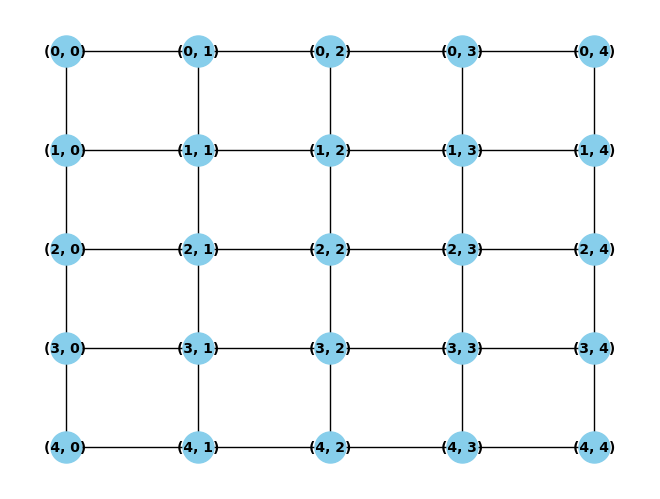

In [3]:
import networkx as nx

# Create node mappings
G = nx.grid_2d_graph(5, 5)

# convert to array
adjacency_matrix = nx.adjacency_matrix(G)
adjacency_matrix = adjacency_matrix.toarray()

# reshape to work with GNN and timeseries data
adjacency_matrix_train = np.repeat(adjacency_matrix[np.newaxis, :, :], train_size, axis=0)
adjacency_matrix_test = np.repeat(adjacency_matrix[np.newaxis, :, :], test_size, axis=0)

#------------------------------------------------------------------------------------------------------------------------------------------------
# Visualise the enviroment for verification
#------------------------------------------------------------------------------------------------------------------------------------------------

import matplotlib.pyplot as plt

# Plot the graph
pos = {(x, y): (y, -x) for x, y in G.nodes()}
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_color='black', font_weight='bold')

plt.axis('off')
plt.show()

### 4. Compile and fit model

In [4]:
import tensorflow as tf

# tf.config.run_functions_eagerly(True)

from Intruder_functionality import machine_learning as ml

data_shape = (trainX.shape[1], trainX.shape[-1])
adjacency_shape = adjacency_matrix_train.shape[1:]

# Create an instance of the GraphConvolutionalNetwork
gcn_model = ml.ML_Intruder(data_shape, adjacency_shape)

# Compile the model
gcn_model.compile()

# Fit the model to the data
gcn_model.fit(trainX, adjacency_matrix_train, trainY, epochs=10, batch_size=1, verbose=2)

2024-01-22 11:05:27.567818: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Node values (input): Tensor("Placeholder:0", shape=(None, 25, 3), dtype=float32)
Adjacency matrix (input): Tensor("Placeholder_1:0", shape=(None, 25, 25), dtype=float32)
Weighted node values by self weights (a_0): Tensor("gcn_layer/mul:0", shape=(None, 25, 3), dtype=float32)
Weighted node values by neighbor weights (a_1): Tensor("gcn_layer/MatMul:0", shape=(None, 25, 3), dtype=float32)
Summed output: Tensor("gcn_layer/Add:0", shape=(None, 25, 3), dtype=float32)
Output after ReLU activation: Tensor("gcn_layer/LeakyRelu:0", shape=(None, 25, 3), dtype=float32)
Epoch 1/10
Node values (input): Tensor("IteratorGetNext:0", shape=(1, 25, 3), dtype=float32)
Adjacency matrix (input): Tensor("model/Cast:0", shape=(1, 25, 25), dtype=float32)
Weighted node values by self weights (a_0): Tensor("model/gcn_layer/mul:0", shape=(1, 25, 3), dtype=float32)
Weighted node values by neighbor weights (a_1): Tensor("model/gcn_layer/MatMul:0", shape=(1, 25, 3), dtype=float32)
Summed output: Tensor("model/gcn_la

In [5]:
# Print the model summary
gcn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 node_input (InputLayer)     [(None, 25, 3)]              0         []                            
                                                                                                  
 adjacency_input (InputLaye  [(None, 25, 25)]             0         []                            
 r)                                                                                               
                                                                                                  
 gcn_layer (GCNLayer)        (None, 25, 3)                2         ['node_input[0][0]',          
                                                                     'adjacency_input[0][0]']     
                                                                                              

### 5. Overall Performance Review 

In [6]:
threshold = 0.5
train_predict = gcn_model.predict(trainX, adjacency_matrix_train)
train_predict_binary = gcn_model.binary_predict(threshold)
test_predict = gcn_model.predict( testX, adjacency_matrix_test)
test_predict_binary = gcn_model.binary_predict(threshold)

Node values (input): Tensor("IteratorGetNext:0", shape=(None, 25, 3), dtype=float32)
Adjacency matrix (input): Tensor("model/Cast:0", shape=(None, 25, 25), dtype=float32)
Weighted node values by self weights (a_0): Tensor("model/gcn_layer/mul:0", shape=(None, 25, 3), dtype=float32)
Weighted node values by neighbor weights (a_1): Tensor("model/gcn_layer/MatMul:0", shape=(None, 25, 3), dtype=float32)
Summed output: Tensor("model/gcn_layer/Add:0", shape=(None, 25, 3), dtype=float32)
Output after ReLU activation: Tensor("model/gcn_layer/LeakyRelu:0", shape=(None, 25, 3), dtype=float32)
200/200 [==============================] - 0s 1ms/step


In [7]:
from sklearn.metrics import accuracy_score, f1_score

# Compute accuracy and F1 score

flattened_trainPredict_binary = train_predict_binary.ravel()
flattened_testPredict_binary = test_predict_binary.ravel()

flattened_trainY = trainY.ravel()
flattened_testY = testY.ravel()

train_accuracy = accuracy_score(flattened_trainY, flattened_trainPredict_binary)
test_accuracy = accuracy_score(flattened_testY, flattened_testPredict_binary)

train_f1_score = f1_score(flattened_trainY, flattened_trainPredict_binary)
test_f1_score = f1_score(flattened_testY, flattened_testPredict_binary)

print('Train Accuracy for average:', train_accuracy)
print('Test Accuracy for average:', test_accuracy)

print('Train F1 Score for average: ', train_f1_score)
print('Test F1 Score for average: ', test_f1_score)

Train Accuracy for average: 0.8799273656600982
Test Accuracy for average: 0.8703216695433862
Train F1 Score for average:  0.7475423930134956
Test F1 Score for average:  0.727135857578679


In [8]:
all_train_actions = pd.DataFrame(flattened_trainPredict_binary)
check_all_train_actions = pd.concat([all_train_actions,pd.DataFrame(flattened_trainY)],axis=1)
all_test_actions = pd.DataFrame(flattened_testPredict_binary)
check_all_test_actions = pd.concat([all_test_actions,pd.DataFrame(flattened_testY)],axis=1)


train_attacks = check_all_train_actions[check_all_train_actions.iloc[:,0] == 1]
train_no_actions = check_all_train_actions[check_all_train_actions.iloc[:,0] == 0]
test_attacks = check_all_test_actions[check_all_test_actions.iloc[:,0] == 1]
test_no_actions = check_all_test_actions[check_all_test_actions.iloc[:,0] == 0]


train_success =  ((train_attacks.iloc[:,1]==1) == True).sum()
train_failed = len(train_attacks)-train_success
train_missed = ((train_no_actions.iloc[:,1]==1) == True).sum()
test_success =  ((test_attacks.iloc[:,1]==1) == True).sum()
test_failed = len(test_attacks)-test_success
test_missed = ((test_no_actions.iloc[:,1]==1) == True).sum()


print('\nFor Training: ')
print('- Number of succesful attacks:', train_success)
print('- Number of failed attacks:', train_failed)
print('- Number of missed attacks:', train_missed)

print('\nFor Testing: ')
print('- Number of succesful attacks:', test_success)
print('- Number of failed attacks:', test_failed)
print('- Number of missed attacks:', test_missed)


For Training: 
- Number of succesful attacks: 66082
- Number of failed attacks: 16126
- Number of missed attacks: 28508

For Testing: 
- Number of succesful attacks: 27529
- Number of failed attacks: 8283
- Number of missed attacks: 12378


/var/folders/b5/lyr1nzqx4kq7mbz3wsnfsxcw0000gn/T/ipykernel_8972/1309024716.py:44: RuntimeWarning: invalid value encountered in scalar divide
  train_total_list.append(train_success/(train_success+train_failed)*100)
/var/folders/b5/lyr1nzqx4kq7mbz3wsnfsxcw0000gn/T/ipykernel_8972/1309024716.py:47: RuntimeWarning: invalid value encountered in scalar divide
  test_total_list.append(test_success/(test_success+test_failed)*100)


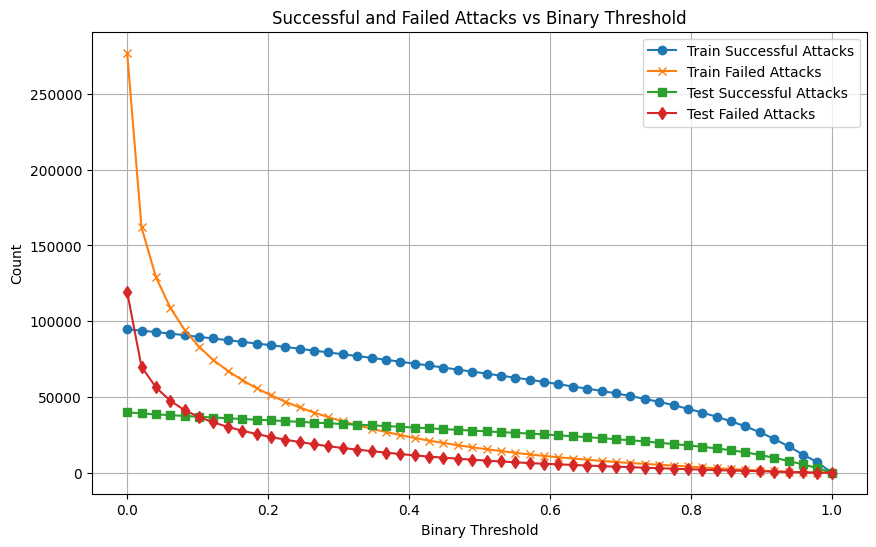

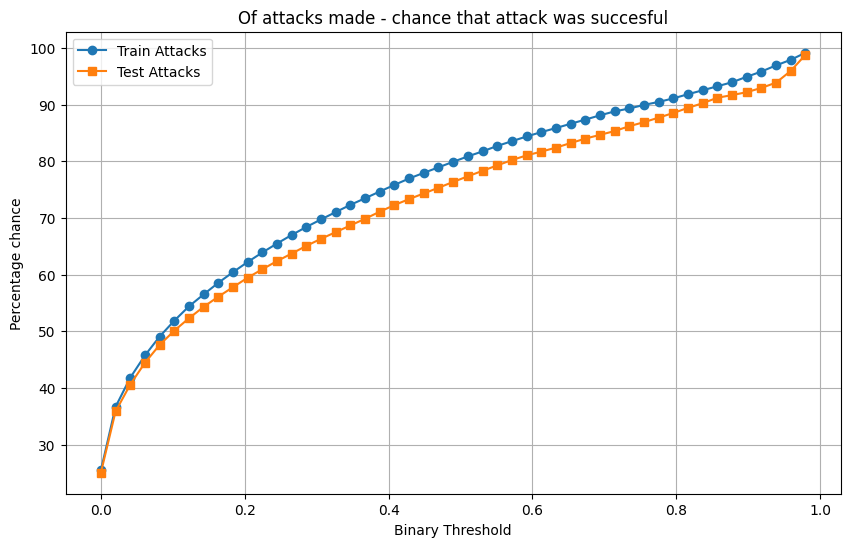

In [9]:
import matplotlib.pyplot as plt

thresholds = np.linspace(0,1,50)
train_success_list = []
train_failed_list = []
test_success_list = []
test_failed_list = []
train_total_list = []
test_total_list = []

for threshold in thresholds:
    # Apply a threshold to convert the probabilities to binary predictions (0 or 1)
    # threshold = 0.5 # Adjust the threshold if needed
    trainPredict_binary = (train_predict > threshold).astype(int)
    testPredict_binary = (test_predict > threshold).astype(int)

    flattened_trainPredict_binary = trainPredict_binary.ravel()
    flattened_testPredict_binary = testPredict_binary.ravel()

    flattened_trainY = trainY.ravel()
    flattened_testY = testY.ravel()

    all_train_actions = pd.DataFrame(flattened_trainPredict_binary)
    check_all_train_actions = pd.concat([all_train_actions,pd.DataFrame(flattened_trainY)],axis=1)
    all_test_actions = pd.DataFrame(flattened_testPredict_binary)
    check_all_test_actions = pd.concat([all_test_actions,pd.DataFrame(flattened_testY)],axis=1)


    train_attacks = check_all_train_actions[check_all_train_actions.iloc[:,0] == 1]
    train_no_actions = check_all_train_actions[check_all_train_actions.iloc[:,0] == 0]
    test_attacks = check_all_test_actions[check_all_test_actions.iloc[:,0] == 1]
    test_no_actions = check_all_test_actions[check_all_test_actions.iloc[:,0] == 0]


    train_success =  ((train_attacks.iloc[:,1]==1) == True).sum()
    train_failed = len(train_attacks)-train_success
    train_missed = ((train_no_actions.iloc[:,1]==1) == True).sum()
    test_success =  ((test_attacks.iloc[:,1]==1) == True).sum()
    test_failed = len(test_attacks)-test_success
    test_missed = ((test_no_actions.iloc[:,1]==1) == True).sum()

    train_success_list.append(train_success)
    train_failed_list.append(train_failed)
    train_total_list.append(train_success/(train_success+train_failed)*100)
    test_success_list.append(test_success)
    test_failed_list.append(test_failed)
    test_total_list.append(test_success/(test_success+test_failed)*100)


plt.figure(figsize=(10, 6))
plt.plot(thresholds, train_success_list, label='Train Successful Attacks', marker='o')
plt.plot(thresholds, train_failed_list, label='Train Failed Attacks', marker='x')
plt.plot(thresholds, test_success_list, label='Test Successful Attacks', marker='s')
plt.plot(thresholds, test_failed_list, label='Test Failed Attacks', marker='d')

plt.title('Successful and Failed Attacks vs Binary Threshold')
plt.xlabel('Binary Threshold')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
# plt.savefig("decay_learning_rate_0.001_success_fail.png")


plt.figure(figsize=(10, 6))
plt.plot(thresholds, train_total_list, label='Train Attacks', marker='o')
plt.plot(thresholds, test_total_list, label='Test Attacks', marker='s')

plt.title('Of attacks made - chance that attack was succesful')
plt.xlabel('Binary Threshold')
plt.ylabel('Percentage chance')
plt.legend()
plt.grid(True)
# plt.savefig("decay_learning_rate_0.001_%_chance.png")
plt.show()


### 6. Performance review for each node

In [10]:
for node in range(0,N-1):
    train_accuracy = accuracy_score(trainY[:,node], trainPredict_binary[:,node])
    test_accuracy = accuracy_score(testY[:,node], testPredict_binary[:,node])

    train_f1_score = f1_score(trainY[:,node], trainPredict_binary[:,node])
    test_f1_score = f1_score(testY[:,node], testPredict_binary[:,node])

    print('\n\nnode: ', node+1)

    print('\nTrain Accuracy for node:', node+1, 'is:' ,train_accuracy)
    print('Test Accuracy for node:', node+1, 'is:' ,test_accuracy)

    print('\nTrain F1 Score for node: ', node+1, 'is:', train_f1_score)
    print('Test F1 Score for node: ', node+1, 'is:', test_f1_score)



node:  1

Train Accuracy for node: 1 is: 0.952115138879548
Test Accuracy for node: 1 is: 0.955436999843088

Train F1 Score for node:  1 is: 0.0
Test F1 Score for node:  1 is: 0.0


node:  2

Train Accuracy for node: 2 is: 0.9821104310982581
Test Accuracy for node: 2 is: 0.9819551231758983

Train F1 Score for node:  2 is: 0.0
Test F1 Score for node:  2 is: 0.0


node:  3

Train Accuracy for node: 3 is: 0.6331293294774363
Test Accuracy for node: 3 is: 0.6544798368115488

Train F1 Score for node:  3 is: 0.0
Test F1 Score for node:  3 is: 0.0


node:  4

Train Accuracy for node: 4 is: 0.5330553500571659
Test Accuracy for node: 4 is: 0.5532716146241958

Train F1 Score for node:  4 is: 0.0
Test F1 Score for node:  4 is: 0.0


node:  5

Train Accuracy for node: 5 is: 0.4746116080435806
Test Accuracy for node: 5 is: 0.4925466813117841

Train F1 Score for node:  5 is: 0.0
Test F1 Score for node:  5 is: 0.0


node:  6

Train Accuracy for node: 6 is: 0.9769991256977605
Test Accuracy for node: 6

In [11]:
for node in range(0,N-1):
    train_actions = pd.DataFrame(trainPredict_binary[:,node])
    check_train_actions = pd.concat([train_actions,pd.DataFrame(trainY[:,node])],axis=1)
    test_actions = pd.DataFrame(testPredict_binary[:,node])
    check_test_actions = pd.concat([test_actions,pd.DataFrame(testY[:,node])],axis=1)


    train_attacks = check_train_actions[check_train_actions.iloc[:,0] == 1]
    train_no_actions = check_train_actions[check_train_actions.iloc[:,0] == 0]
    test_attacks = check_test_actions[check_test_actions.iloc[:,0] == 1]
    test_no_actions = check_test_actions[check_test_actions.iloc[:,0] == 0]


    train_success =  ((train_attacks.iloc[:,1]==1) == True).sum()
    train_failed = len(train_attacks)-train_success
    train_missed = ((train_no_actions.iloc[:,1]==1) == True).sum()
    test_success =  ((test_attacks.iloc[:,1]==1) == True).sum()
    test_failed = len(test_attacks)-test_success
    test_missed = ((test_no_actions.iloc[:,1]==1) == True).sum()


    print('\n\nNode: ', node+1)
    print('\nFor Training: ')
    print('- Number of succesful attacks:', train_success)
    print('- Number of failed attacks:', train_failed)
    print('- Number of missed attacks:', train_missed)

    print('For Testing: ')
    print('- Number of succesful attacks:', test_success)
    print('- Number of failed attacks:', test_failed)
    print('- Number of missed attacks:', test_missed)



Node:  1

For Training: 
- Number of succesful attacks: 0
- Number of failed attacks: 0
- Number of missed attacks: 712
For Testing: 
- Number of succesful attacks: 0
- Number of failed attacks: 0
- Number of missed attacks: 284


Node:  2

For Training: 
- Number of succesful attacks: 0
- Number of failed attacks: 0
- Number of missed attacks: 266
For Testing: 
- Number of succesful attacks: 0
- Number of failed attacks: 0
- Number of missed attacks: 115


Node:  3

For Training: 
- Number of succesful attacks: 0
- Number of failed attacks: 0
- Number of missed attacks: 5455
For Testing: 
- Number of succesful attacks: 0
- Number of failed attacks: 0
- Number of missed attacks: 2202


Node:  4

For Training: 
- Number of succesful attacks: 0
- Number of failed attacks: 0
- Number of missed attacks: 6943
For Testing: 
- Number of succesful attacks: 0
- Number of failed attacks: 0
- Number of missed attacks: 2847


Node:  5

For Training: 
- Number of succesful attacks: 0
- Number of 

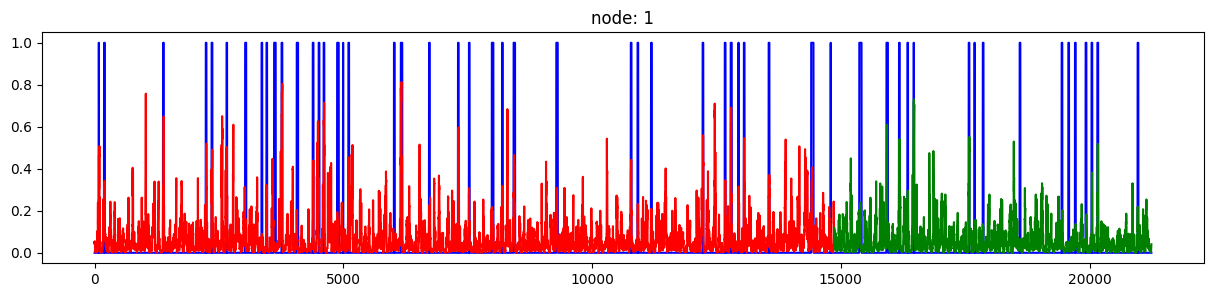

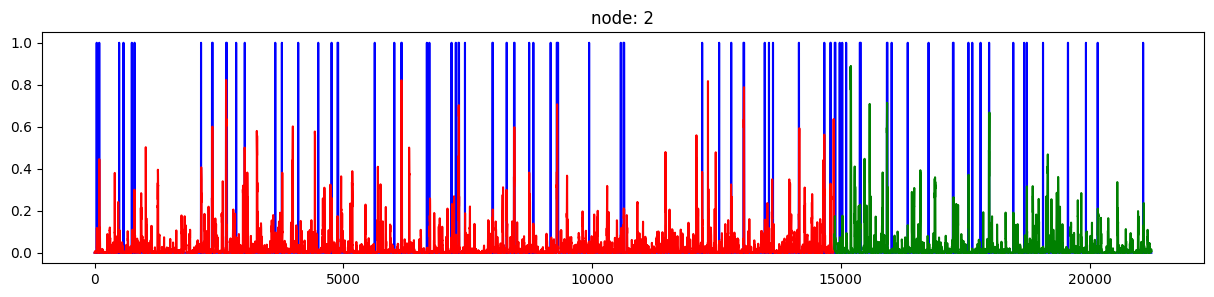

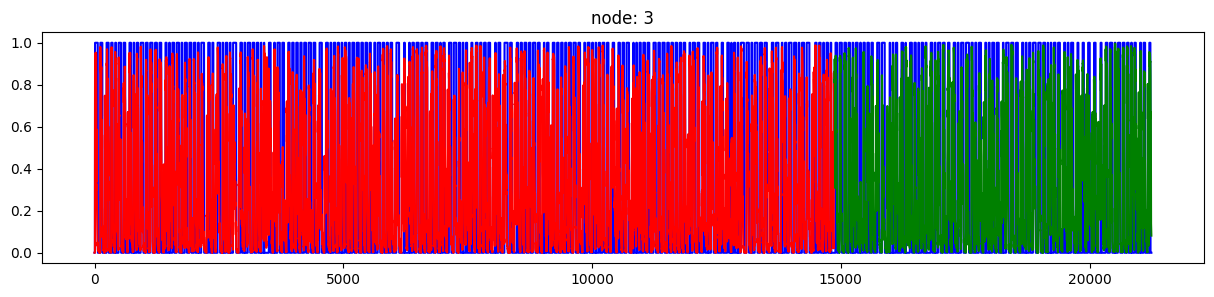

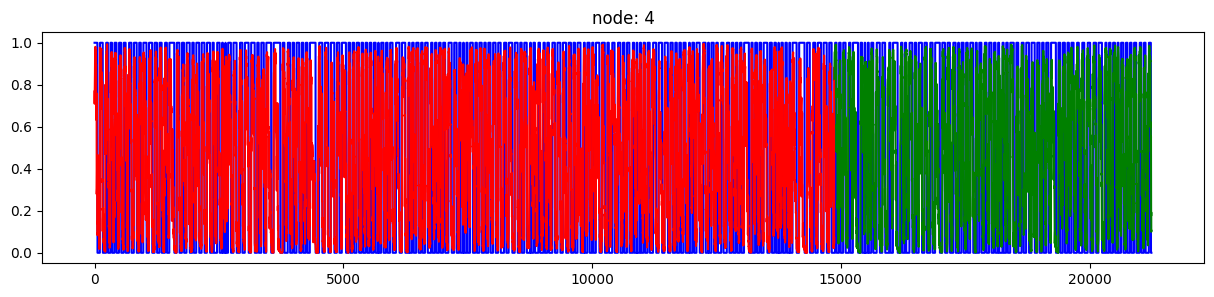

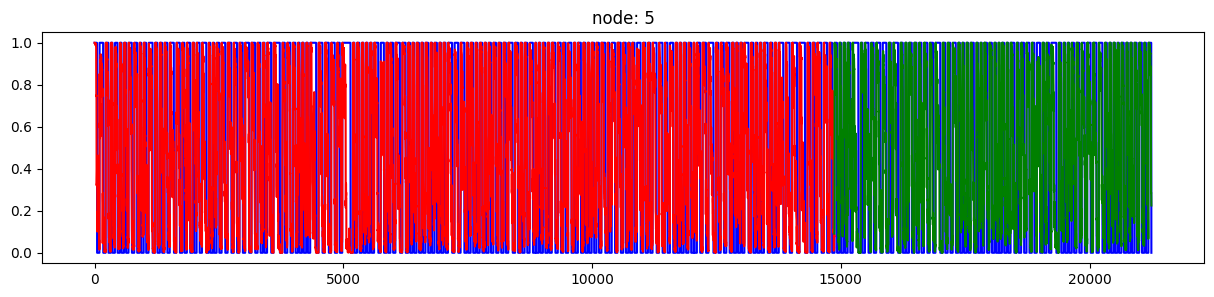

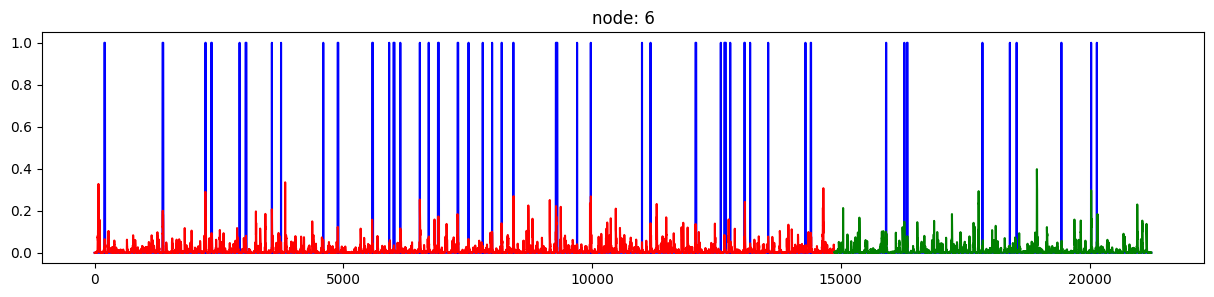

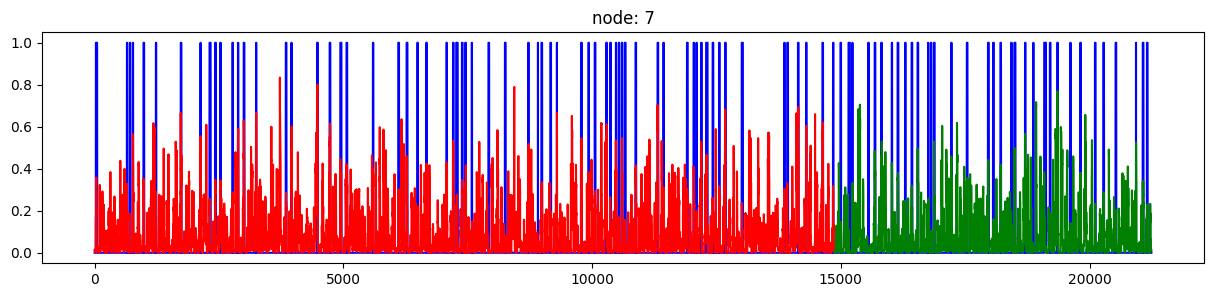

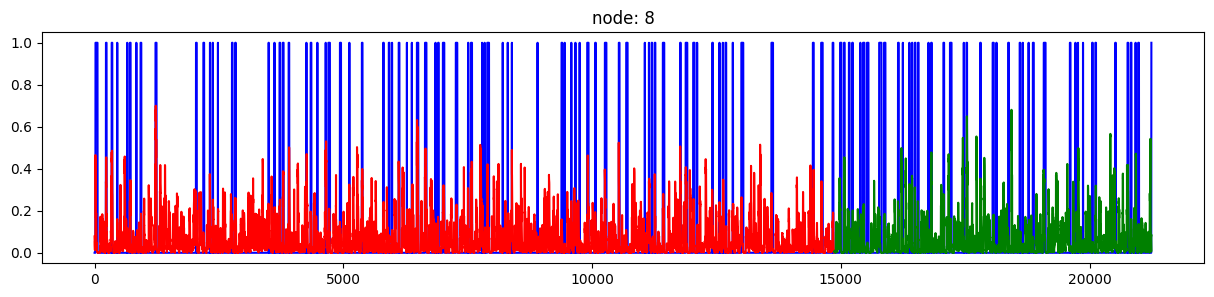

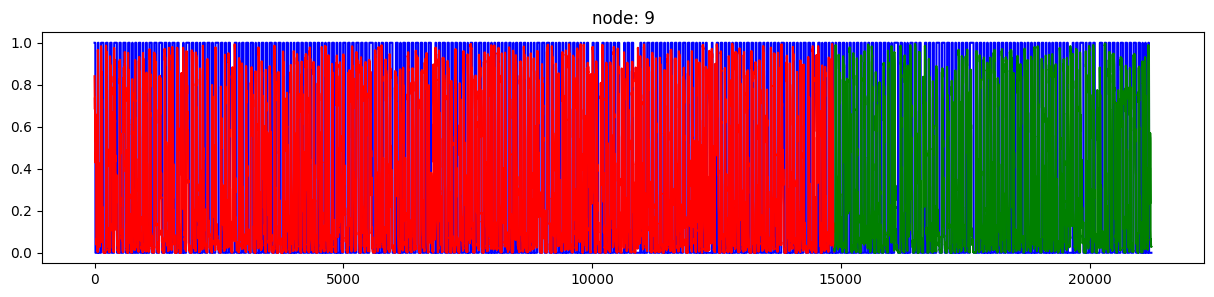

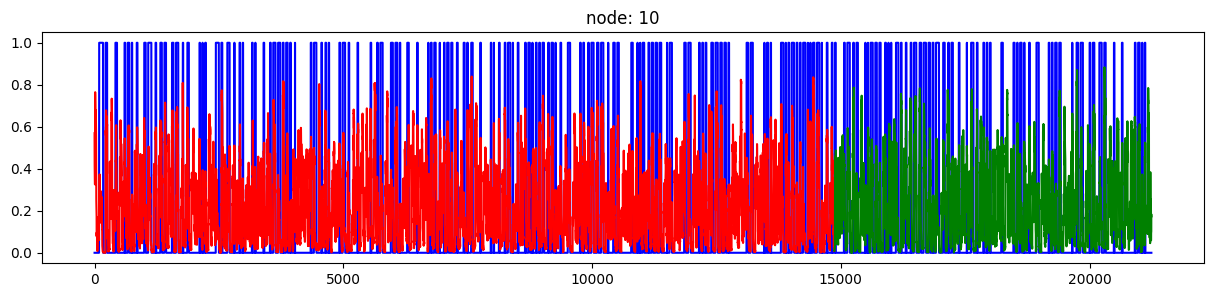

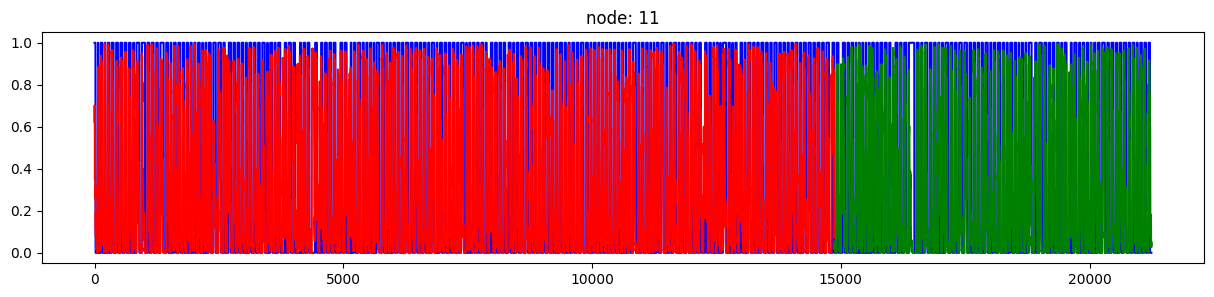

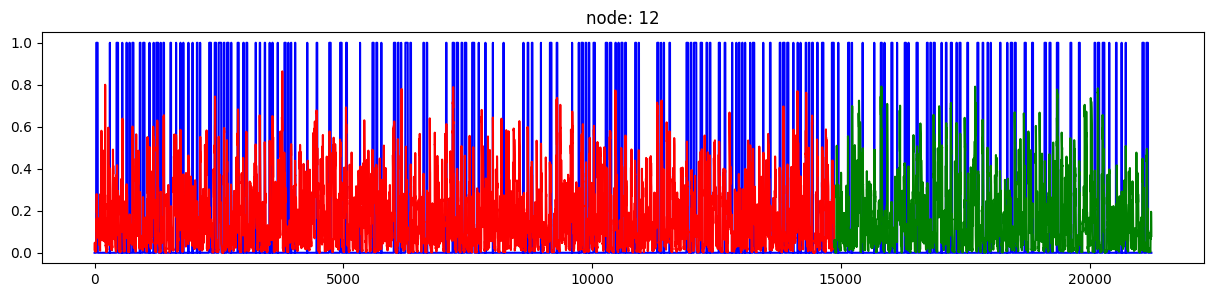

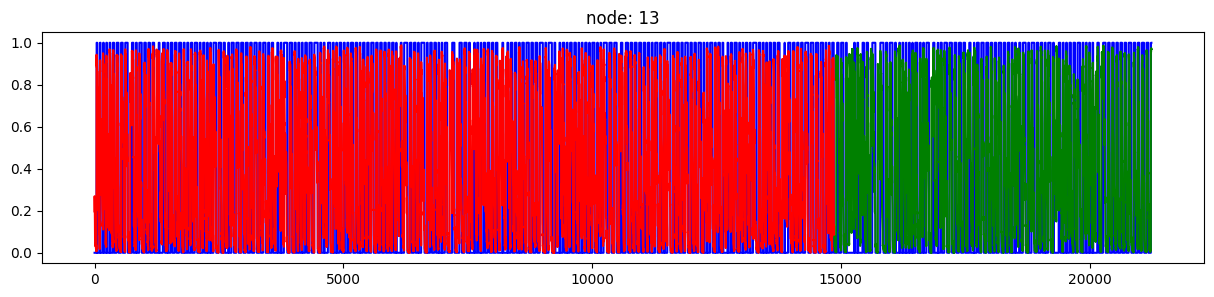

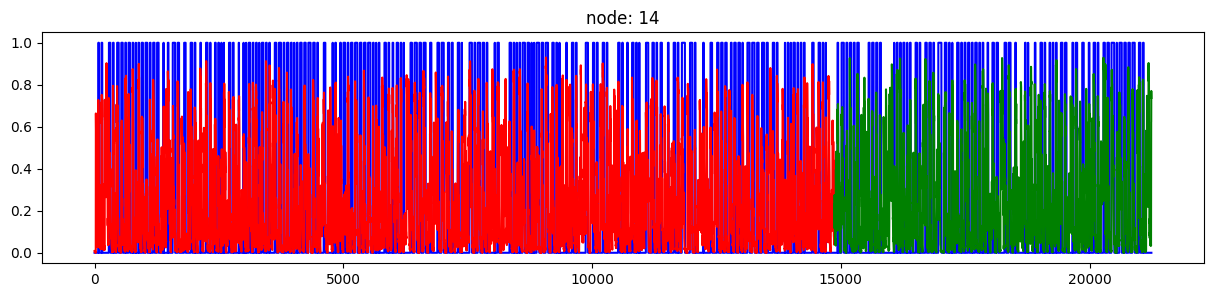

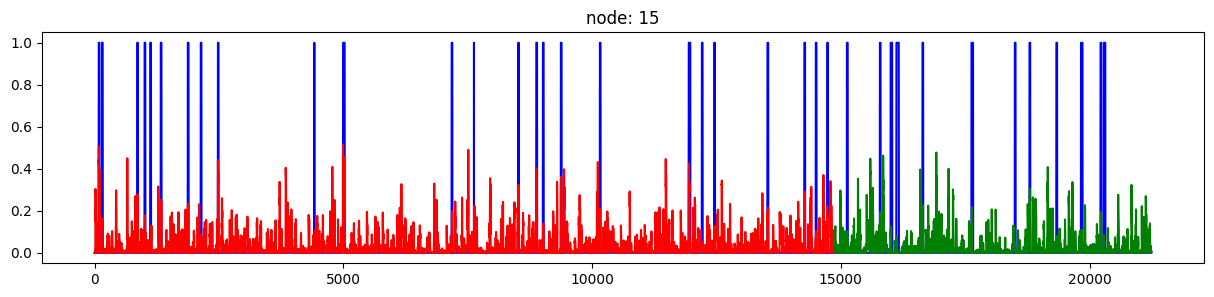

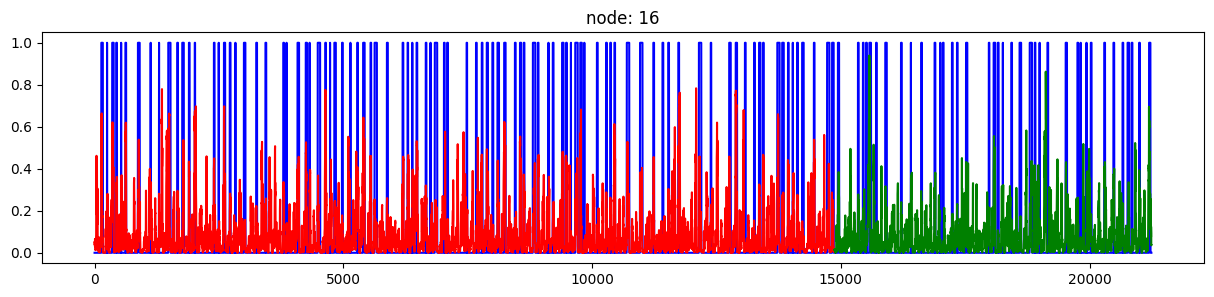

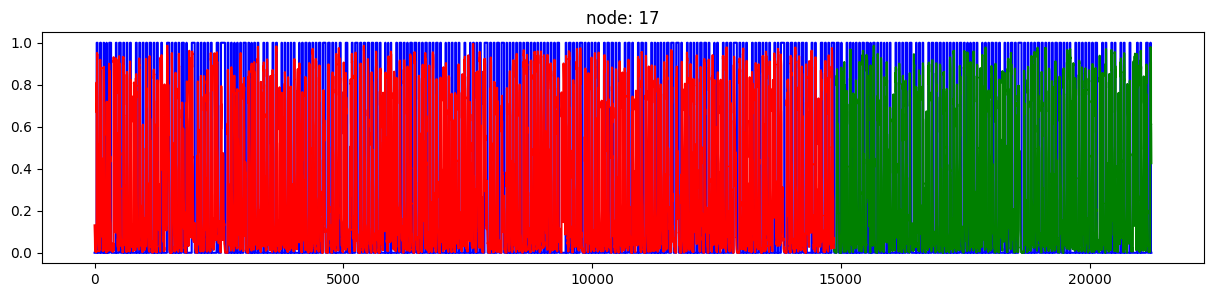

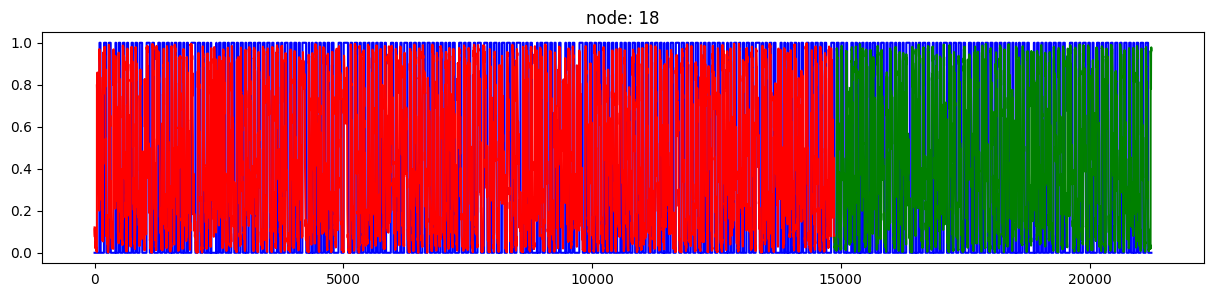

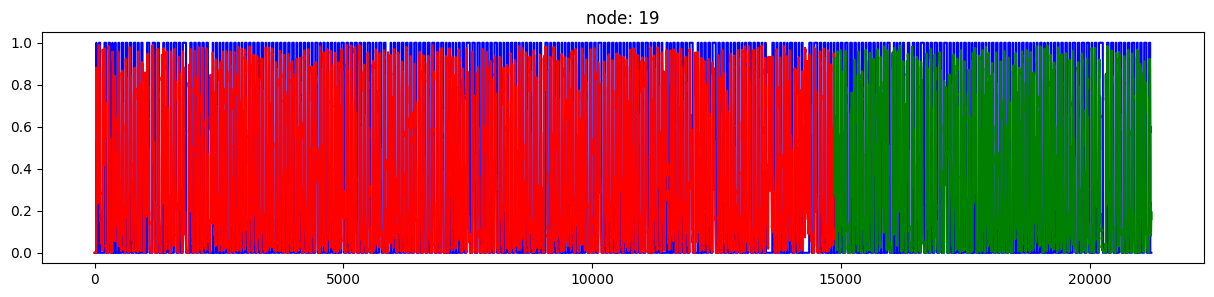

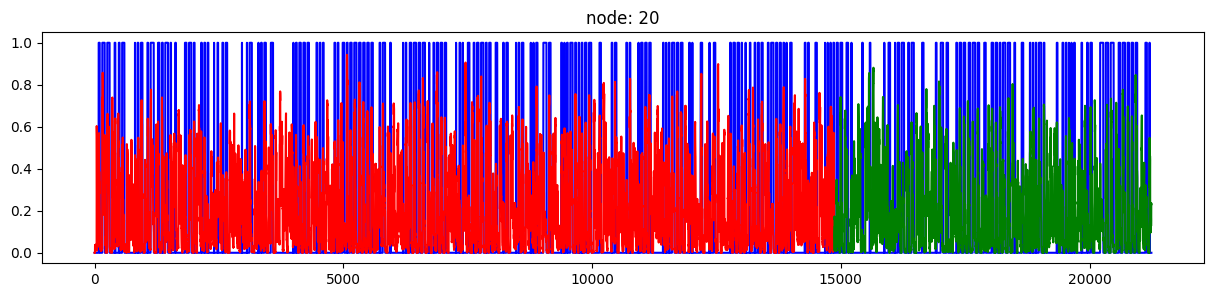

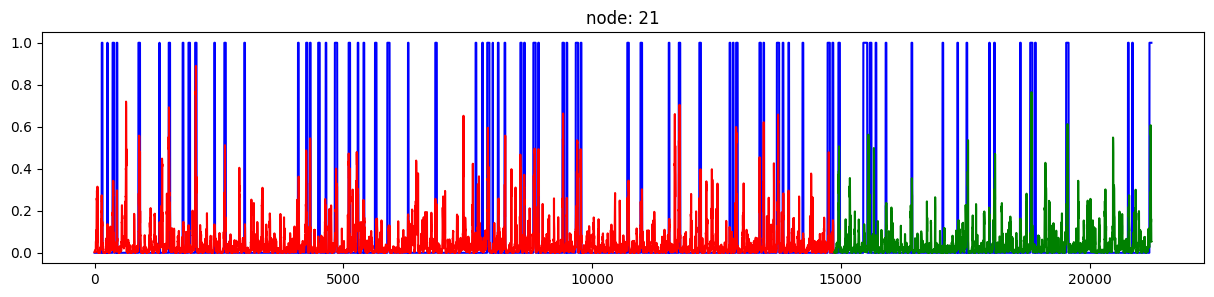

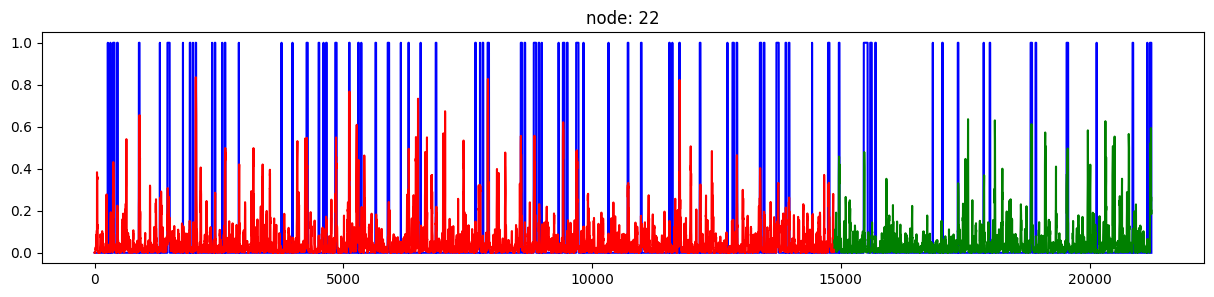

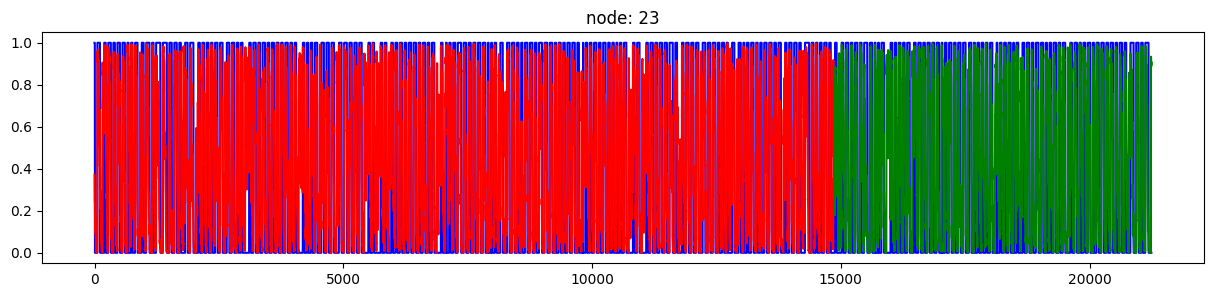

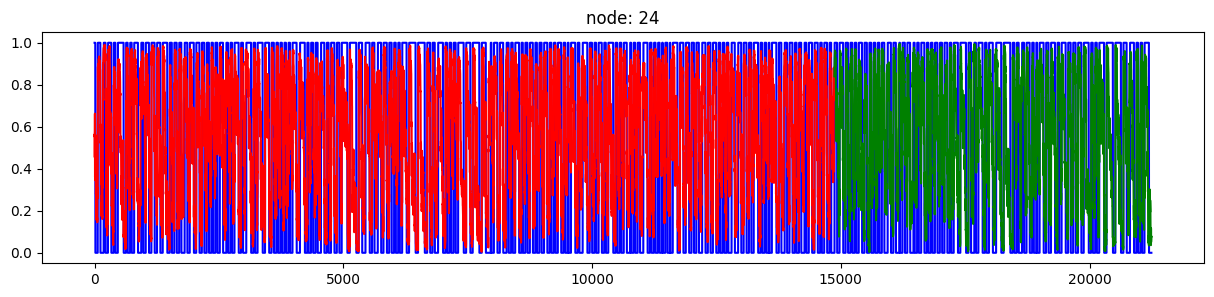

In [12]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset[:,N*3:N*4])
trainPredictPlot[:,:] = np.nan
trainPredictPlot[0:len(train_predict),:] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset[:,N*3:N*4])
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict):len(dataset[:,N*3:N*4]),:] = test_predict
# plot baseline and predictions
for col in range(0,N-1):
    plt.figure(figsize=(15, 3))
    plt.title('node: ' + str(col+1))
    plt.plot(dataset[:,N*3+col],'b')
    plt.plot(trainPredictPlot[:,col],'r')
    plt.plot(testPredictPlot[:,col],'g')
    # plt.savefig('node: ' + str(col+1) + ' sigmoid_output.png') 
    plt.show()